# Tabular data manipulation
 
> Setelah membaca ini, pembaca diharapkan dapat membaca, membersihkan, dan memanipulasi data tabular.

## Membaca dan membersihkan data

Proses analisis data sepenuhnya disesuaikan dengan tujuan dan sifat dari data yang akan di analisis. Dalam praktik ini, kita akan memproses data waterlevel dari pengukuran MAWS Tanjung Priok. Data sampel tersedia dalam rentang waktu Agustus - September 2021, dengan resolusi temporal 10 menit.

> Tujuan: kita akan membuat rata-rata jam berdasarkan hari untuk mendapatkan pola harian. Output akhir adalah rata-rata data waterlevel dalam satu hari (jam 00 - 23).

> Disclaimer: Tujuan dari pengolahan ini disesuaikan untuk fokus pada bagaimana menghandel sampel data tabular meteorologi maritim khususnya menggunakan pandas, bukan untuk menganalisisnya secara ilmiah.

### Load data

In [1]:
# load module & data
import pandas as pd

file1 = "../data/aws_priok_202108.csv"
file2 = "../data/aws_priok_202109.xlsx"
df1 = pd.read_csv(file1)
df2 = pd.read_excel(file2)

In [2]:
# cek data sekilas menggunakan method .head()
display(df1.head(3)) # menampilkan 3 baris
display(df2.head(3))

Unnamed: 0                 time  windspeed  winddir  temp    rh  pressure  \
0           0  2021-08-18 16:38:00        1.2    142.0  27.7  72.1    1010.7   
1           1  2021-08-30 17:04:00        0.5    135.0  28.8  76.3    1010.4   
2           2  2021-08-19 05:05:00        4.6    321.0  29.8  67.3    1009.4   

   rain  solrad  netrad  watertemp  waterlevel  ta_min  ta_max  pancilevel  \
0   0.0     0.0     0.0       30.6       1.952     0.0     0.0         0.0   
1   0.0     0.0     0.0       30.8       1.724     0.0     0.0         0.0   
2   0.0   388.8     0.0       30.4       1.814     0.0     0.0         0.0   

   pancitemp  Year  Month  
0        0.0  2021      8  
1        0.0  2021      8  
2        0.0  2021      8

Unnamed: 0                time  windspeed  winddir  temp    rh  pressure  \
0           0 2021-09-07 03:33:00        0.4      314  27.6  83.3    1012.9   
1           1 2021-09-23 12:47:00        2.3       81  29.5  70.7    1010.4   
2           2 2021-09-27 10:09:00        5.3       23  29.8  78.6    1006.5   

   rain  solrad  netrad  watertemp  waterlevel  ta_min  ta_max  pancilevel  \
0   1.2   568.4       0       30.5       1.721       0       0           0   
1   0.0     0.0       0       31.2       1.795       0       0           0   
2   0.0    72.8       0       31.5       1.795       0       0           0   

   pancitemp  Year  Month  
0          0  2021      9  
1          0  2021      9  
2          0  2021      9

### Seleksi dan menggabungkan data

In [3]:
# seleksi & gabungkan data
cols = ['time','waterlevel']
df = pd.concat([df1[cols], df2[cols]])
df

time  waterlevel
0      2021-08-18 16:38:00       1.952
1      2021-08-30 17:04:00       1.724
2      2021-08-19 05:05:00       1.814
3      2021-08-09 06:23:00       1.762
4      2021-08-01 22:27:00       1.535
...                    ...         ...
39340  2021-09-05 05:43:00       1.862
39341  2021-09-12 18:23:00       1.538
39342  2021-09-21 14:22:00       2.007
39343  2021-09-06 13:16:00       2.156
39344  2021-09-15 20:22:00       1.304

[75765 rows x 2 columns]

### Cek nilai `NaN` dan statistik

time          0
waterlevel    0
dtype: int64

time           object
waterlevel    float64
dtype: object

count      mean       std    min    25%    50%    75%   max
waterlevel  75765.0  1.854415  0.207846  0.438  1.724  1.802  2.047  4.38

<Axes: >

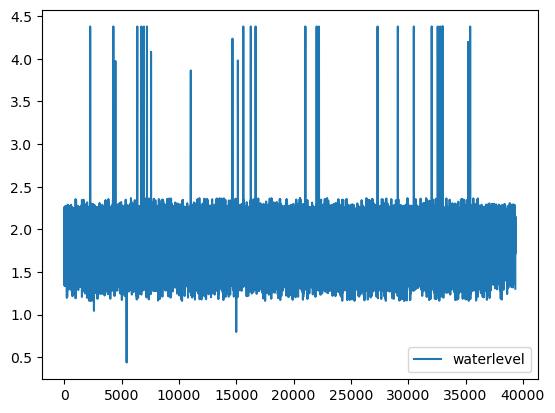

In [4]:
# Check nan values
display(df.isna().sum())
print(30*"=")

# check data types
display(df.dtypes)
print(30*"=")

# check stats
display(df.describe().T)
print(30*"=")

# quick plot
df.plot()

---


| Point penting | Tindak anjut | Metode |
| :- | :- | - |
| Tipe data waktu bukan datetime | ubah ke datetime | pandas to_datetime | 
| Urutan data acak | urutkan sesuai waktu | pandas sort_values |
| Terdapat spikes | eliminasi | pandas filtering |

---

### Transform, Sort, dan Filter

In [5]:
# TO DATETIME
df['time'] = pd.to_datetime(df['time'])

# SORTING
df = df.sort_values(by='time')
df = df.set_index('time', drop=True)

# FILTERING: eliminasi spikes jika >99% dan <1%
q99 = df['waterlevel'].quantile(.99)
q01 = df['waterlevel'].quantile(.01)
df_filtered = df[(df['waterlevel'] > q01) & (df['waterlevel'] < q99)]
df_filtered

waterlevel
time                           
2021-08-01 03:00:00       1.723
2021-08-01 03:01:00       1.722
2021-08-01 03:02:00       1.724
2021-08-01 03:03:00       1.726
2021-08-01 03:04:00       1.725
...                         ...
2021-09-30 23:54:00       1.795
2021-09-30 23:55:00       1.795
2021-09-30 23:56:00       1.795
2021-09-30 23:57:00       1.795
2021-09-30 23:58:00       1.795

[74246 rows x 1 columns]

<Axes: xlabel='time'>

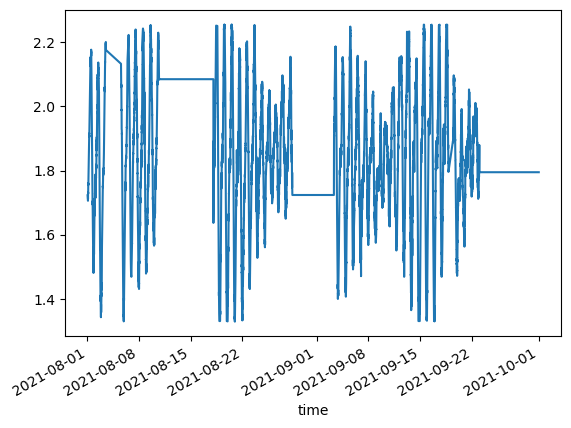

In [6]:
# QUICK PLOT
df_filtered['waterlevel'].plot()

## Memanipulasi data

---
Berdasarkan proses sebelumnya, terdapat tiga point penting.

| Point penting | Tindak anjut | Metode |
| :- | :- | - |
| Tidak terdapat nan values, namun nilai stagnan pada periode waktu tertentu | replace ke nan dan eliminasi | pandas filtering & apply method| 
| Resolusi temporal per 10 menit | ambil snapshoot tiap jam | pandas filtering |
| Resolusi temporal per jam | ambil rata-rata dalam periode keseluruhan | pandas groupby and agregation by mean |

---

### Filtering Nilai Stagnan

In [7]:
def remove_stagnan(val1, val2):
    diff = abs(val1-val2)
    if diff == 0.0:
        return 1
    else:
        return 0

df_filtered['waterlevellag1' = df_filtered['waterlevel'].shift(periods=1)
df_filtered['to_remove'] = df_filtered.apply(lambda row: remove_stanan(row['waterlevel'], row['waterlevellag1']), axis=1)
df_filtered

/tmp/ipykernel_39362/1703409140.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['waterlevellag1'] = df_filtered['waterlevel'].shift(periods=1)
/tmp/ipykernel_39362/1703409140.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['to_remove'] = df_filtered.apply(lambda row: remove_stagnan(row['waterlevel'], row['waterlevellag1']), axis=1)


waterlevel  waterlevellag1  to_remove
time                                                      
2021-08-01 03:00:00       1.723             NaN          0
2021-08-01 03:01:00       1.722           1.723          0
2021-08-01 03:02:00       1.724           1.722          0
2021-08-01 03:03:00       1.726           1.724          0
2021-08-01 03:04:00       1.725           1.726          0
...                         ...             ...        ...
2021-09-30 23:54:00       1.795           1.795          1
2021-09-30 23:55:00       1.795           1.795          1
2021-09-30 23:56:00       1.795           1.795          1
2021-09-30 23:57:00       1.795           1.795          1
2021-09-30 23:58:00       1.795           1.795          1

[74246 rows x 3 columns]

In [8]:
# FILTER
df_filtered_new = df_filtered[['waterlevel']][df_filtered['to_remove'] != 1]
# QUICK PLOT
df_filtered_new.describe().T

count      mean       std   min    25%    50%    75%    max
waterlevel  39709.0  1.842266  0.208091  1.33  1.708  1.847  1.993  2.255

BEFORE


<Axes: >

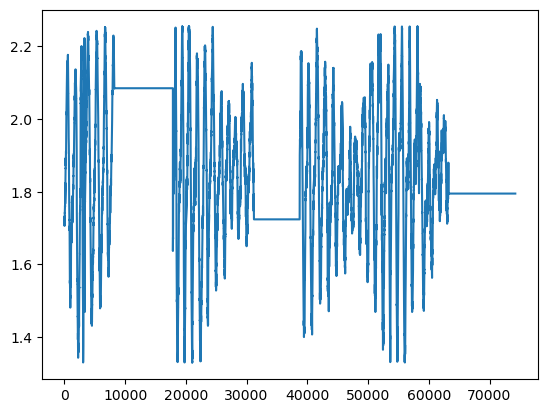

In [9]:
# QUICK PLOT
print("BEFORE"
display(df_filtered.reset_index(drop=True)['waterlevel'].plot())

AFTER


<Axes: >

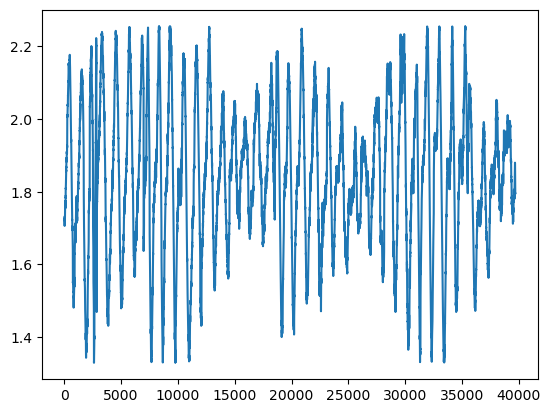

In [10]:
print("AFTER")
display(df_filtered_new.reset_index(drop=True)['waterlevel'].plot())

### Filtering per jam

<Axes: >

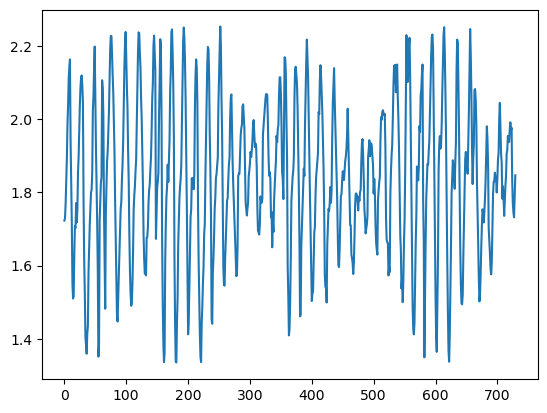

In [11]:
# SNAPSHOOT PER 1 JAM
df_1jam = df_filtered_new[df_filtered_new.index.minute == 0]
display(df_1jam.reset_index(drop=True)['waterlevel'].plot())

### Agregasi statistik

In [12]:
# RATA-RATA KESELURUHAN DATA
df_1jam_grouped = df_1jam.groupby(df_1jam.index.hour)
df_1jam_grouped

In [22]:
# CEK ISI DARI df_1jam_grouped
for key, val in df_1jam_grouped:
    print("Jam ke", key, type(val))

Jam ke 0 <class 'pandas.core.frame.DataFrame'>
Jam ke 1 <class 'pandas.core.frame.DataFrame'>
Jam ke 2 <class 'pandas.core.frame.DataFrame'>
Jam ke 3 <class 'pandas.core.frame.DataFrame'>
Jam ke 4 <class 'pandas.core.frame.DataFrame'>
Jam ke 5 <class 'pandas.core.frame.DataFrame'>
Jam ke 6 <class 'pandas.core.frame.DataFrame'>
Jam ke 7 <class 'pandas.core.frame.DataFrame'>
Jam ke 8 <class 'pandas.core.frame.DataFrame'>
Jam ke 9 <class 'pandas.core.frame.DataFrame'>
Jam ke 10 <class 'pandas.core.frame.DataFrame'>
Jam ke 11 <class 'pandas.core.frame.DataFrame'>
Jam ke 12 <class 'pandas.core.frame.DataFrame'>
Jam ke 13 <class 'pandas.core.frame.DataFrame'>
Jam ke 14 <class 'pandas.core.frame.DataFrame'>
Jam ke 15 <class 'pandas.core.frame.DataFrame'>
Jam ke 16 <class 'pandas.core.frame.DataFrame'>
Jam ke 17 <class 'pandas.core.frame.DataFrame'>
Jam ke 18 <class 'pandas.core.frame.DataFrame'>
Jam ke 19 <class 'pandas.core.frame.DataFrame'>
Jam ke 20 <class 'pandas.core.frame.DataFrame'>
Ja

time              0        1         2         3         4        5        6   \
waterlevel  1.571161  1.64344  1.690821  1.765226  1.798323  1.84497  1.86025   

time              7        8         9   ...      14      15        16  \
waterlevel  1.890414  1.89529  1.922452  ...  2.0694  2.0435  1.988424   

time              17        18        19        20        21      22       23  
waterlevel  1.905515  1.793061  1.711758  1.641379  1.595036  1.5665  1.58976  

[1 rows x 24 columns]

<Axes: xlabel='time'>

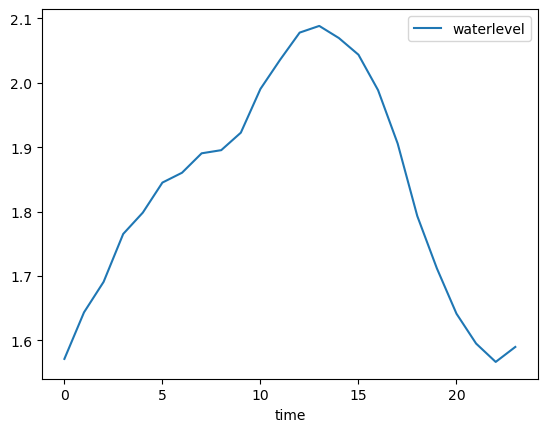

In [23]:
df_1jam_mean = df_1jam_grouped.mean)
display(df_1jam_mean.T)
display(df_1jam_mean.plot())